<a href="https://colab.research.google.com/github/PoliNemkova/conflict_prediction_2025/blob/main/Sudan/%5B4weekly%2C_since_2020%5D_%5B4%5D_Regression_Test_Sudan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Housekeeping and Data

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
#%load_ext autotime
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [244]:
import pandas as pd
data = pd.read_csv('/content/gdrive/MyDrive/CONFLICT PREDICTION/Fall 2024/4weekly_Sudan_since2020.csv')

In [ ]:
# skipped GPT labels step for now

In [220]:
data.columns

Index(['Unnamed: 0', 'timeslot', 'goldsteinscale', 'goldstein_min_max',
       'avgtone', 'events_density', 'unique_articles', 'nummentions',
       'numsources', 'numarticles', 'cosine_similarity_positive',
       'cosine_similarity_negative', 'avg_embeddings', 'topic', 'topic_1',
       'dominance_score_1', 'topic_2', 'dominance_score_2', 'topic_3',
       'dominance_score_3', 'sentiment', 'sentiment_std', 'strings',
       'summaries', 'keywords', 'STARTDATE', 'ENDDATE',
       'sum(ACLED_Fatalities)', '5th_Week_Fatalities', 'importance'],
      dtype='object')

In [245]:
data['goldstein_min'] = data['goldstein_min_max'].apply(lambda x: float(str(x).strip('[]').split(',')[0]))
data['goldstein_max'] = data['goldstein_min_max'].apply(lambda x: float(str(x).strip('[]').split(',')[1]))

In [246]:
data.iloc[1]

,1
Unnamed: 0,1
timeslot,0
goldsteinscale,2.117284
goldstein_min_max,"[-10.0, 8.0]"
avgtone,-2.035824
events_density,81
unique_articles,13
nummentions,420
numsources,81
numarticles,360


In [247]:
# fixing keywords feature (splitting them into separate columns)

import pandas as pd

# Expand the 'keywords' column into separate columns
list_keys = data['keywords'].apply(lambda x: x.strip('[]').replace('\'', '').split(','))

# Create a DataFrame with the expanded keys
words_df = pd.DataFrame(list_keys.tolist(), columns=[f'key{i+1}' for i in range(10)])

# Concatenate the new columns with the original DataFrame
data = pd.concat([data.drop(columns=['keywords']), words_df], axis=1)


Encodings

In [249]:
data.columns

Index(['Unnamed: 0', 'timeslot', 'goldsteinscale', 'goldstein_min_max',
       'avgtone', 'events_density', 'unique_articles', 'nummentions',
       'numsources', 'numarticles', 'cosine_similarity_positive',
       'cosine_similarity_negative', 'avg_embeddings', 'topic', 'topic_1',
       'dominance_score_1', 'topic_2', 'dominance_score_2', 'topic_3',
       'dominance_score_3', 'sentiment', 'sentiment_std', 'strings',
       'summaries', 'STARTDATE', 'ENDDATE', 'sum(ACLED_Fatalities)',
       '5th_Week_Fatalities', 'importance', 'goldstein_min', 'goldstein_max',
       'key1', 'key2', 'key3', 'key4', 'key5', 'key6', 'key7', 'key8', 'key9',
       'key10'],
      dtype='object')

In [251]:
# encoding categorical data

from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()

categorical_columns = [ 'topic_1','topic_2', 'topic_3',
                        #'STARTDATE', 'ENDDATE',
                       'key1', 'key2', 'key3', 'key4', 'key5', 'key6', 'key7',
                        'key8', 'key9', 'key10']

for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])


In [252]:
# fancy date encoding
# I'm using only STARTDATE here, but can experiment with other ways

import pandas as pd

# Assuming 'date_column' is in datetime format
df = pd.DataFrame()
data['STARTDATE'] = pd.to_datetime(data['STARTDATE'])
df['year'] = data['STARTDATE'].dt.year
df['month'] = data['STARTDATE'].dt.month
df['day'] = data['STARTDATE'].dt.day
df['day_of_week'] = data['STARTDATE'].dt.dayofweek  # Monday=0, Sunday=6

import numpy as np

# Month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Day of the week
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

data[df.columns] = df

In [12]:
data['5th_Week_Fatalities'].describe()

,5th_Week_Fatalities
count,198.000000
mean,135.191919
std,216.015894
min,0.000000
25%,12.000000
50%,37.000000
75%,202.750000
max,1669.000000


In [253]:
y = np.log10(data['5th_Week_Fatalities']+0.5) #offsetting to handle zeros
y.describe()

,5th_Week_Fatalities
count,198.000000
mean,1.676753
std,0.681195
min,-0.301030
25%,1.096910
50%,1.573877
75%,2.308030
max,3.222586


In [254]:
data['5th_Week_Fatalities'][data['5th_Week_Fatalities'] <= 0]

,5th_Week_Fatalities
7,0


Dealing with average embeddings (making those values into separate columns)

In [255]:
def parse_embedding(s):
    s = s.strip('[]')        # remove brackets
    values = s.split()       # split by whitespace
    return list(map(float, values))

data['avg_embeddings'] = data['avg_embeddings'].apply(parse_embedding)
X_embeddings = np.vstack(data['avg_embeddings'].values)


In [257]:
# shape should be num of examples X 768 - bert encoding size
X_embeddings.shape

(198, 768)

In [258]:
# doing PCA, since total size of df is 198, but feature set is ~800

from sklearn.decomposition import PCA

pca = PCA(n_components=50, random_state=42)  # for example, reduce to 50 dimensions
reduced_embeddings = pca.fit_transform(X_embeddings)  # X_embeddings is (198, 768)
# Now reduced_embeddings is (198, 50)

# Create a DataFrame for the reduced embeddings with appropriate column names
embedding_cols = [f"pca_{i}" for i in range(reduced_embeddings.shape[1])]
df_reduced = pd.DataFrame(reduced_embeddings, columns=embedding_cols)

# Concatenate the original DataFrame and the embeddings DataFrame
X_full = pd.concat([data.reset_index(drop=True), df_reduced.reset_index(drop=True)], axis=1)


In [259]:
X_full

,Unnamed: 0,timeslot,goldsteinscale,goldstein_min_max,avgtone,events_density,unique_articles,nummentions,numsources,numarticles,...,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49
0,0,26,1.337931,"[-10.0, 9.0]",-2.967304,58,16,279,58,279,...,0.034790,0.029938,0.037650,-0.035997,0.048984,0.065478,0.044152,-0.014979,0.025593,0.049781
1,1,0,2.117284,"[-10.0, 8.0]",-2.035824,81,13,420,81,360,...,0.049635,0.040872,0.010072,0.055233,-0.028996,-0.082190,-0.034335,-0.015304,0.030659,0.074544
2,2,1,0.178462,"[-10.0, 7.0]",-4.545631,65,5,261,65,261,...,-0.070116,0.064657,-0.183983,-0.035416,-0.115085,0.016028,0.021585,0.113168,0.112479,0.080455
3,3,2,-0.210000,"[-5.0, 3.4]",-3.572745,10,4,49,10,49,...,-0.142130,-0.036547,0.012070,0.130727,-0.110063,0.126198,-0.027818,-0.053949,-0.036972,0.155943
4,4,3,1.166667,"[-9.0, 10.0]",-3.365027,6,3,19,6,19,...,-0.463619,-0.384437,0.133056,0.257163,0.417209,0.057435,0.145278,0.239573,0.165736,0.046984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,193,235,-2.000000,"[-2.0, -2.0]",-2.460457,1,1,6,1,6,...,-0.134212,-0.546670,-0.468218,0.187637,-0.096375,0.226734,-0.172358,-0.355492,-0.295148,0.380748
194,194,236,0.297059,"[-10.0, 4.0]",-5.283870,34,6,98,34,98,...,-0.135241,0.102943,0.119442,-0.156296,-0.153025,0.082613,-0.024723,0.018780,-0.009087,0.046114
195,195,237,2.976923,"[-2.0, 7.0]",-1.490722,13,5,64,13,64,...,-0.186090,0.123666,0.062982,-0.010710,-0.070609,0.172877,-0.099493,0.169306,-0.023390,0.101883
196,196,239,1.503571,"[-10.0, 8.0]",-2.172034,56,13,294,56,294,...,-0.059486,0.095989,0.028223,-0.062011,-0.021940,0.067593,-0.122159,0.006085,-0.010029,-0.025290


In [260]:
data.columns

Index(['Unnamed: 0', 'timeslot', 'goldsteinscale', 'goldstein_min_max',
       'avgtone', 'events_density', 'unique_articles', 'nummentions',
       'numsources', 'numarticles', 'cosine_similarity_positive',
       'cosine_similarity_negative', 'avg_embeddings', 'topic', 'topic_1',
       'dominance_score_1', 'topic_2', 'dominance_score_2', 'topic_3',
       'dominance_score_3', 'sentiment', 'sentiment_std', 'strings',
       'summaries', 'STARTDATE', 'ENDDATE', 'sum(ACLED_Fatalities)',
       '5th_Week_Fatalities', 'importance', 'goldstein_min', 'goldstein_max',
       'key1', 'key2', 'key3', 'key4', 'key5', 'key6', 'key7', 'key8', 'key9',
       'key10', 'year', 'month', 'day', 'day_of_week', 'month_sin',
       'month_cos', 'day_of_week_sin', 'day_of_week_cos', 'is_weekend'],
      dtype='object')

In [261]:
# normalizing values

from sklearn.preprocessing import StandardScaler
# Prepare the data

# removing columns we don't need for regression
X = X_full.drop(columns=['Unnamed: 0',  'goldstein_min_max',
                       'avg_embeddings', 'strings',
                       'summaries',  'sum(ACLED_Fatalities)', 'importance',
                       '5th_Week_Fatalities', 'STARTDATE','ENDDATE'])



# Standardize the numerical features
numerical_features = [ 'goldsteinscale', 'avgtone', 'events_density',
                      'unique_articles', 'nummentions', 'numsources',
                      'numarticles', 'cosine_similarity_positive',
                      'cosine_similarity_negative', 'dominance_score_1',  'dominance_score_2',
                      'dominance_score_3', 'sentiment', 'sentiment_std',
                      'goldstein_min', 'goldstein_max'
                      ]

scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])


In [262]:
X.columns

Index(['timeslot', 'goldsteinscale', 'avgtone', 'events_density',
       'unique_articles', 'nummentions', 'numsources', 'numarticles',
       'cosine_similarity_positive', 'cosine_similarity_negative', 'topic',
       'topic_1', 'dominance_score_1', 'topic_2', 'dominance_score_2',
       'topic_3', 'dominance_score_3', 'sentiment', 'sentiment_std',
       'goldstein_min', 'goldstein_max', 'key1', 'key2', 'key3', 'key4',
       'key5', 'key6', 'key7', 'key8', 'key9', 'key10', 'year', 'month', 'day',
       'day_of_week', 'month_sin', 'month_cos', 'day_of_week_sin',
       'day_of_week_cos', 'is_weekend', 'pca_0', 'pca_1', 'pca_2', 'pca_3',
       'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10',
       'pca_11', 'pca_12', 'pca_13', 'pca_14', 'pca_15', 'pca_16', 'pca_17',
       'pca_18', 'pca_19', 'pca_20', 'pca_21', 'pca_22', 'pca_23', 'pca_24',
       'pca_25', 'pca_26', 'pca_27', 'pca_28', 'pca_29', 'pca_30', 'pca_31',
       'pca_32', 'pca_33', 'pca_34', 'pca_35', 'pc

## **1. Testing with NO LLM feature**

### ⭐ AutoML adjusted for a small dataset NO LLM FEATURE (via hyperparams and CV)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 hours 45 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_unknownUser_g0nufz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.099 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
22:31:55.799: _train param, Dropping bad and constant columns: [day_of_week_sin, day_of_week, day_of_week_cos, is_weekend]

█
22:31:58.962: _train param, Dropping bad and constant columns: [day_of_week_sin, day_of_week, day_of_week_cos, is_weekend]


22:31:59.945: _train param, Dropping bad and constant columns: [day_of_week_sin, day_of_week, day_of_week_cos, is_weekend]
22:31:59.945: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 198.0.
22:31:59.947: _train param, Dropping bad and constant columns: [day_of_week_sin, day_of_week, day_of_week_cos, is_weekend]

████
22:32:06.760: _train param, Dropping bad and constant columns: [day_of_week_sin, day_of_week, day_of_week_cos, is_weekend]

██
22:32:21.777: _train param, Dropping bad and constant columns: [day_of_week_sin, day_of_week, day_of_we

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


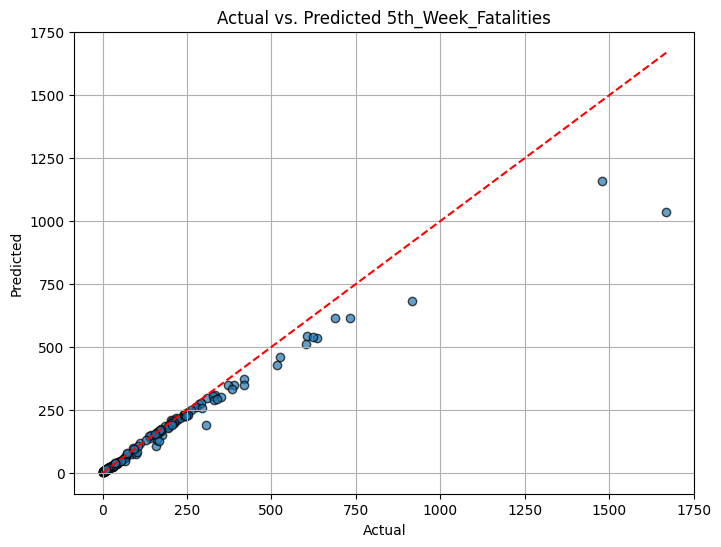

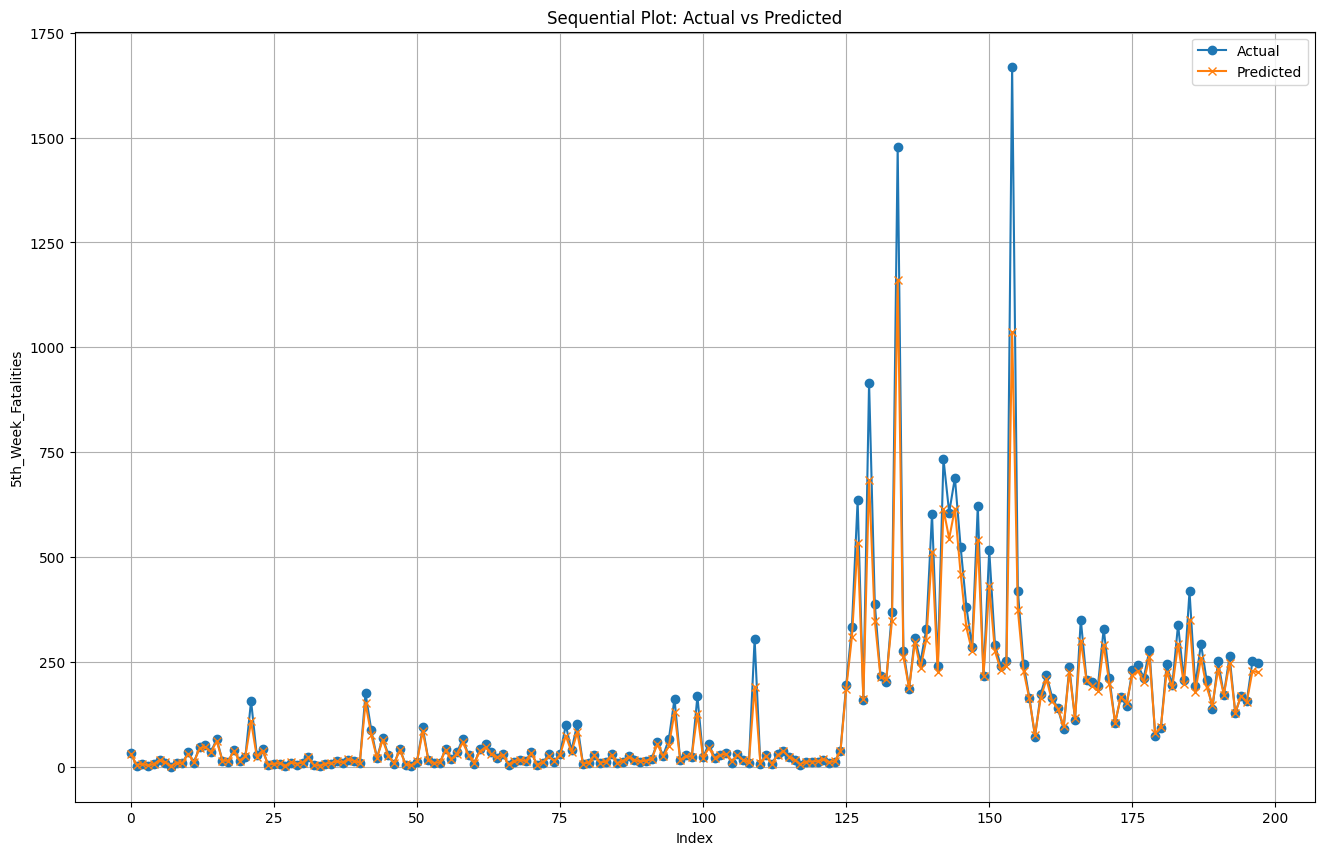

In [263]:
# AutoML but adjusted for a small dataset

# Install H2O
#!pip install h2o

# Import H2O and other required libraries
import h2o
from h2o.automl import H2OAutoML
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Start the H2O cluster
h2o.init()

# target value
#y = np.log10(data['5th_Week_Fatalities']+0.5)
y = np.log(data['5th_Week_Fatalities']+0.5) # small value offset is needed due to having 0 in dataset
#y = data['5th_Week_Fatalities'].to_list() # absolute values performs very BAD since the data is heavily skewed

#X = X.drop(columns = ['5th_Week_Fatalities']) # just double check that target values are not in the feature set by any chance


# Combine X and y into a single DataFrame for H2O
data_h2o = pd.concat([X, pd.Series(y, name='5th_Week_Fatalities')], axis=1)

# Convert the DataFrame to an H2O Frame
data_h2o = h2o.H2OFrame(data_h2o)

# Specify predictors (features) and response (target)
predictors = X.columns.tolist()
response = '5th_Week_Fatalities'

# Run H2O AutoML with cross-validation
aml = H2OAutoML(max_models=10,          # Limit the number of models
                max_runtime_secs=300,   # Total runtime of 5 minutes
                nfolds=10,               # Use 5-fold cross-validation
                seed=42,                # Ensure reproducibility
                distribution='huber',   # handling outliers
                stopping_metric='RMSE') # handling outliers

aml.train(x=predictors, y=response, training_frame=data_h2o)

# Display the leaderboard
print("\nLeaderboard:")
print(aml.leaderboard)

# Get the best model
best_model = aml.leader

# Evaluate the best model using cross-validation metrics
print("\nModel Performance (Cross-Validation Metrics):")
print(best_model.cross_validation_metrics_summary())



##___________PLOTTING RESULTS________________##

#___ sctter plot___#

# Assuming you have already run the code up to obtaining the best_model

# 1. Generate predictions
# `best_model.predict()` requires an H2OFrame. You've already got `data_h2o` which includes the target.
# To simulate a true prediction scenario, you might want to split your data into train/test first.
# For demonstration, let's assume you just want in-sample predictions:
preds_h2o = best_model.predict(data_h2o)

# Convert predictions to a Pandas DataFrame
preds_df = preds_h2o.as_data_frame()

from sklearn.metrics import median_absolute_error
medae = median_absolute_error(y, preds_df)
print("Median Absolute Error:", medae)

# 2. Invert the log transformation on the predictions
# Recall that you defined your target as:
# y = np.log(data['5th_Week_Fatalities'] + 0.5)

# So, to invert:
# original_scale = exp(predictions) - 0.5

preds_inverted = np.exp(preds_df['predict']) - 0.5

# 3. Get the original target values (before transformation)
# You have them in your original `data` variable. If `data` and `X` align row by row,
# we can just take `data['5th_Week_Fatalities']`.

actual = data['5th_Week_Fatalities'].values

# 4. Plot Actual vs Predicted
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(actual, preds_inverted, alpha=0.7, edgecolors='k')
plt.title("Actual vs. Predicted 5th_Week_Fatalities")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--')  # Perfect correlation line
plt.grid(True)
plt.show()

##_____linear_plot_____##

# Convert predictions and actual values into the same format for sequential plotting
# Ensure they are aligned (e.g., based on index in your dataset)
preds_sequential = preds_inverted  # Already inverted predictions
actual_sequential = actual  # Actual target values

# Create an index for sequential plotting
index = range(len(actual_sequential))

# Plot actual vs. predicted values sequentially
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))
plt.plot(index, actual_sequential, label="Actual", linestyle='-', marker='o')
plt.plot(index, preds_sequential, label="Predicted", linestyle='-', marker='x')
plt.title("Sequential Plot: Actual vs Predicted")
plt.xlabel("Index")
plt.ylabel("5th_Week_Fatalities")
plt.legend()
plt.grid(True)
plt.show()


# Shutdown H2O (optional)
#h2o.shutdown(prompt=False)


In [265]:
np.log(data['5th_Week_Fatalities']+0.5).describe()

,5th_Week_Fatalities
count,198.000000
mean,3.860867
std,1.568511
min,-0.693147
25%,2.525729
50%,3.623985
75%,5.314434
max,7.420279


In [264]:
preds_df

,predict
0,3.411086
1,1.693194
2,1.983016
3,1.269489
4,1.894307
...,...
193,4.857990
194,5.133676
195,5.039135
196,5.431927


In [266]:
from sklearn.metrics import median_absolute_error
medae = median_absolute_error(y, preds_df)
print("Median Absolute Error:", medae)

Median Absolute Error: 0.07432737821486746


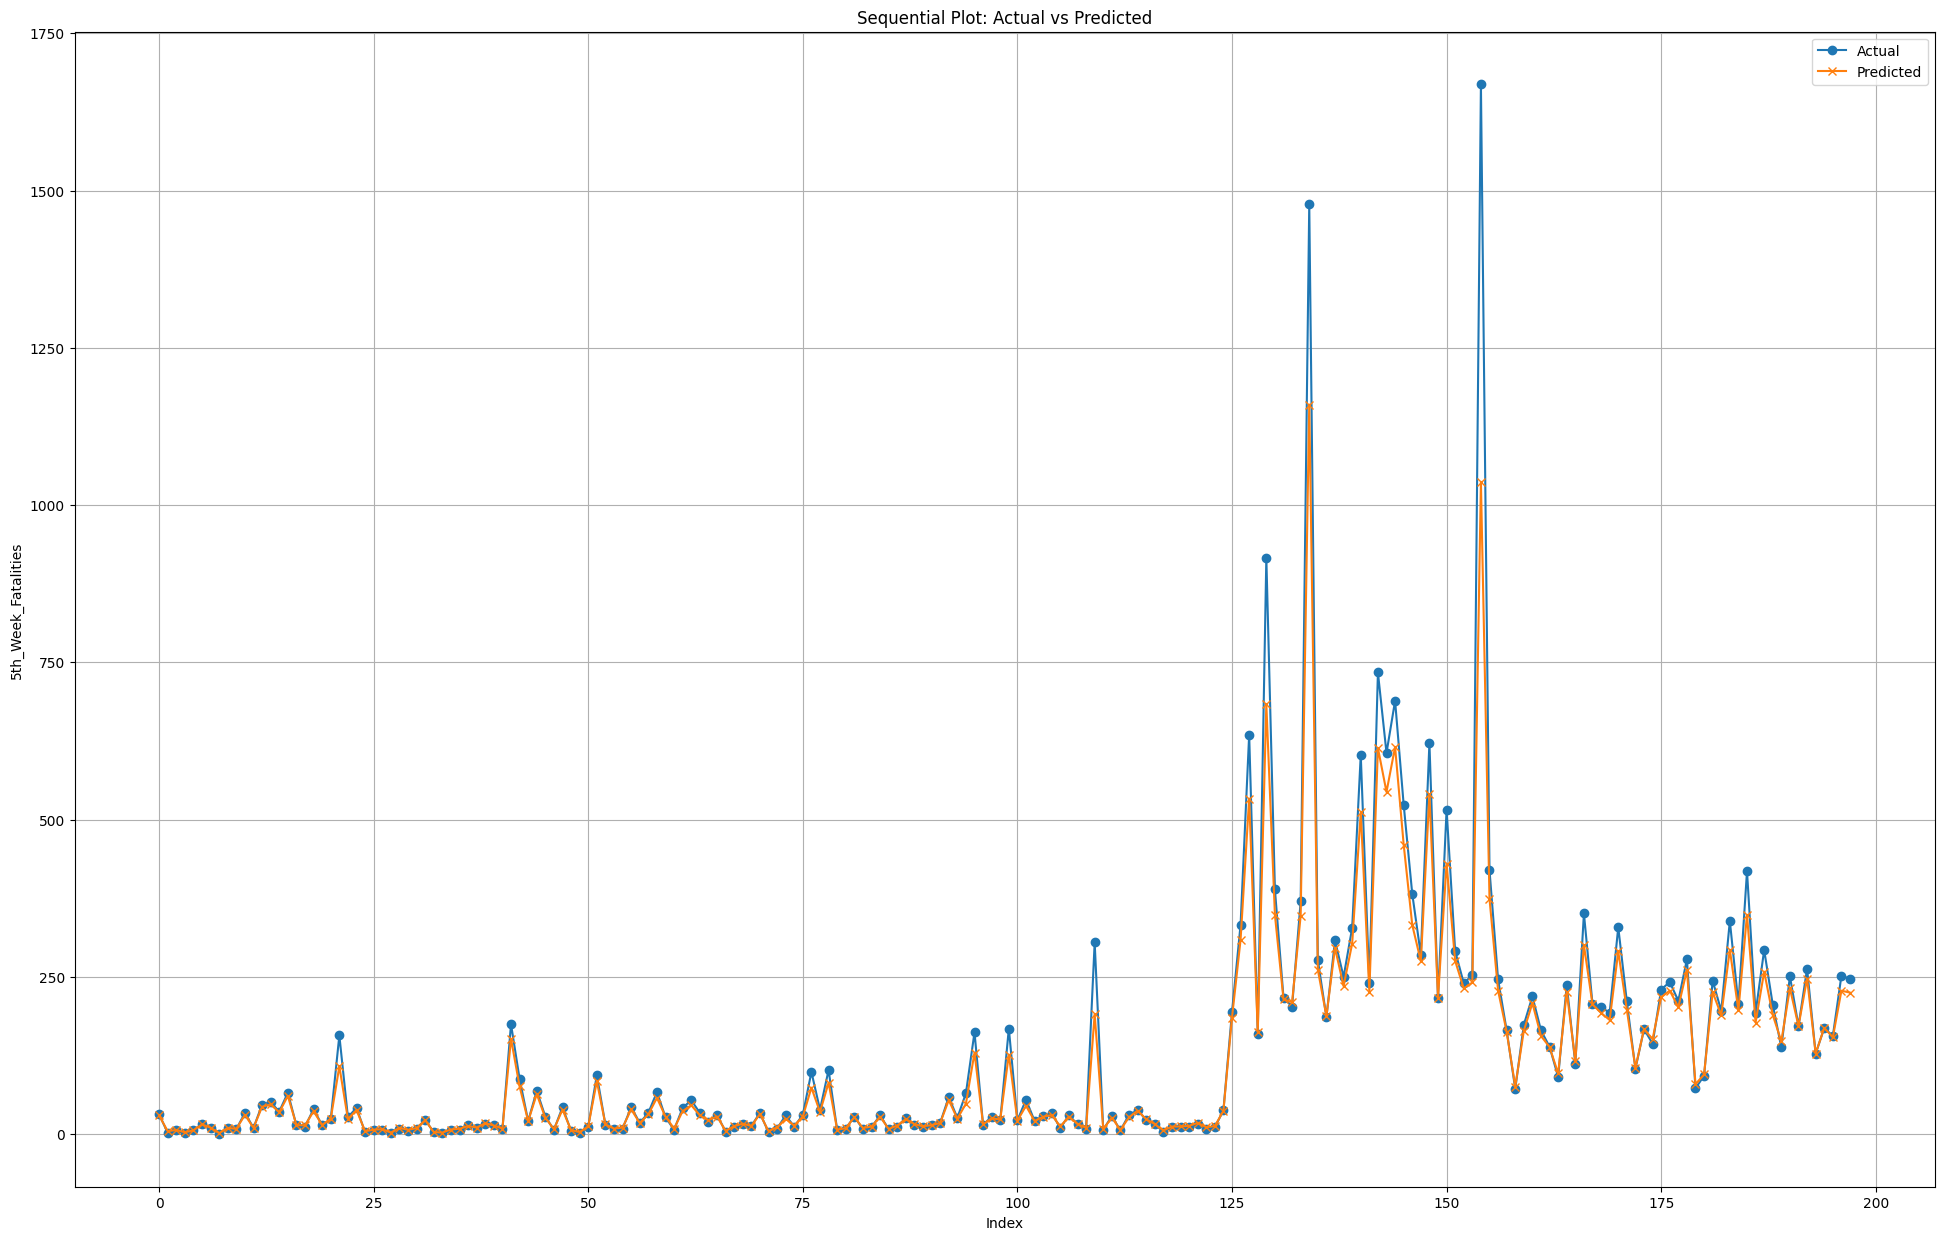

In [267]:
# Convert predictions and actual values into the same format for sequential plotting
# Ensure they are aligned (e.g., based on index in your dataset)
preds_sequential = preds_inverted  # Already inverted predictions
actual_sequential = actual  # Actual target values

# Create an index for sequential plotting
index = range(len(actual_sequential))

# Plot actual vs. predicted values sequentially
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 15))
plt.plot(index, actual_sequential, label="Actual", linestyle='-', marker='o')
plt.plot(index, preds_sequential, label="Predicted", linestyle='-', marker='x')
plt.title("Sequential Plot: Actual vs Predicted")
plt.xlabel("Index")
plt.ylabel("5th_Week_Fatalities")
plt.legend()
plt.grid(True)
plt.show()


In [74]:
data['5th_Week_Fatalities'].describe()

,5th_Week_Fatalities
count,198.000000
mean,135.191919
std,216.015894
min,0.000000
25%,12.000000
50%,37.000000
75%,202.750000
max,1669.000000


### Exploring multicollinearity

In [268]:
X.columns

Index(['timeslot', 'goldsteinscale', 'avgtone', 'events_density',
       'unique_articles', 'nummentions', 'numsources', 'numarticles',
       'cosine_similarity_positive', 'cosine_similarity_negative', 'topic',
       'topic_1', 'dominance_score_1', 'topic_2', 'dominance_score_2',
       'topic_3', 'dominance_score_3', 'sentiment', 'sentiment_std',
       'goldstein_min', 'goldstein_max', 'key1', 'key2', 'key3', 'key4',
       'key5', 'key6', 'key7', 'key8', 'key9', 'key10', 'year', 'month', 'day',
       'day_of_week', 'month_sin', 'month_cos', 'day_of_week_sin',
       'day_of_week_cos', 'is_weekend', 'pca_0', 'pca_1', 'pca_2', 'pca_3',
       'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10',
       'pca_11', 'pca_12', 'pca_13', 'pca_14', 'pca_15', 'pca_16', 'pca_17',
       'pca_18', 'pca_19', 'pca_20', 'pca_21', 'pca_22', 'pca_23', 'pca_24',
       'pca_25', 'pca_26', 'pca_27', 'pca_28', 'pca_29', 'pca_30', 'pca_31',
       'pca_32', 'pca_33', 'pca_34', 'pca_35', 'pc

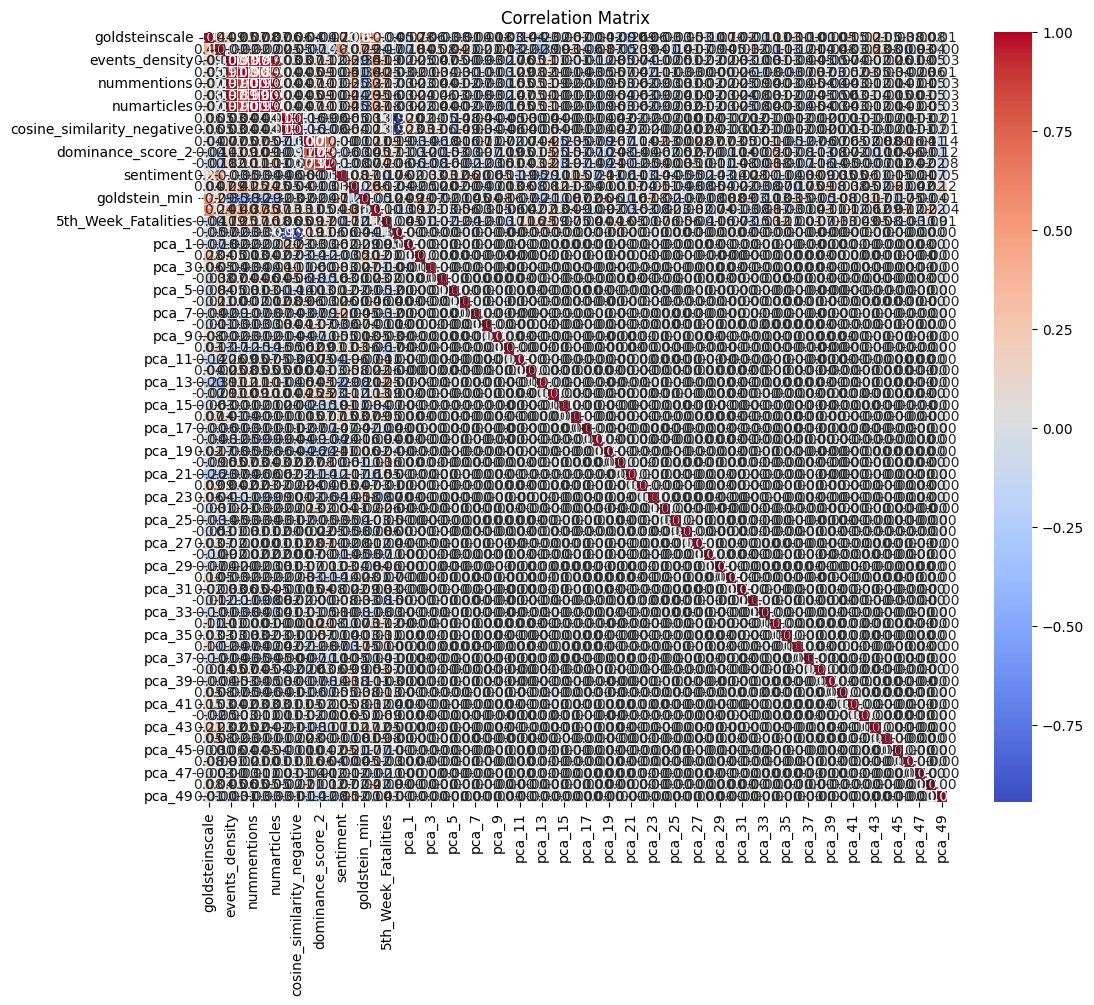

In [269]:
# exploring multicoluniarity

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

test = X
test['5th_Week_Fatalities'] = data['5th_Week_Fatalities']
num_feat = numerical_features + ['5th_Week_Fatalities'] + ['pca_0',
       'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8',
       'pca_9', 'pca_10', 'pca_11', 'pca_12', 'pca_13', 'pca_14', 'pca_15',
       'pca_16', 'pca_17', 'pca_18', 'pca_19', 'pca_20', 'pca_21', 'pca_22',
       'pca_23', 'pca_24', 'pca_25', 'pca_26', 'pca_27', 'pca_28', 'pca_29',
       'pca_30', 'pca_31', 'pca_32', 'pca_33', 'pca_34', 'pca_35', 'pca_36',
       'pca_37', 'pca_38', 'pca_39', 'pca_40', 'pca_41', 'pca_42', 'pca_43',
       'pca_44', 'pca_45', 'pca_46', 'pca_47', 'pca_48', 'pca_49']

# Calculate the correlation matrix
correlation_matrix = X[num_feat].corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [270]:
# Set the correlation threshold
correlation_threshold = 0.8

# Find pairs of features with correlation above the threshold
high_corr_pairs = [
    (feature1, feature2, correlation_matrix.loc[feature1, feature2])
    for feature1 in correlation_matrix.columns
    for feature2 in correlation_matrix.columns
    if feature1 != feature2 and abs(correlation_matrix.loc[feature1, feature2]) > correlation_threshold
]

# Display the pairs
if high_corr_pairs:
    print("Highly correlated feature pairs (threshold > 0.8):")
    for pair in high_corr_pairs:
        print(f"{pair[0]} and {pair[1]}: correlation = {pair[2]:.2f}")
else:
    print("No highly correlated feature pairs found.")


Highly correlated feature pairs (threshold > 0.8):
events_density and unique_articles: correlation = 0.91
events_density and nummentions: correlation = 0.97
events_density and numsources: correlation = 0.97
events_density and numarticles: correlation = 0.97
unique_articles and events_density: correlation = 0.91
unique_articles and nummentions: correlation = 0.90
unique_articles and numsources: correlation = 0.89
unique_articles and numarticles: correlation = 0.90
nummentions and events_density: correlation = 0.97
nummentions and unique_articles: correlation = 0.90
nummentions and numsources: correlation = 0.99
nummentions and numarticles: correlation = 1.00
numsources and events_density: correlation = 0.97
numsources and unique_articles: correlation = 0.89
numsources and nummentions: correlation = 0.99
numsources and numarticles: correlation = 0.99
numarticles and events_density: correlation = 0.97
numarticles and unique_articles: correlation = 0.90
numarticles and nummentions: correla

*These were received based on results of AutoML without LLM feature

### Feature Importance

the problem here is that best performing model is Ensemble model hence it's a bit tricky to analyze feature importance. I will go with  number 2 leader since the scores are relatively similar

In [271]:
best_model = aml.leader

# Retrieve the leaderboard
leaderboard = aml.leaderboard
# Display the leaderboard
print(leaderboard)


model_id                                                     rmse       mse       mae     rmsle    mean_residual_deviance
GBM_5_AutoML_7_20241213_223155                           0.865671  0.749386  0.660898  0.27408                   0.71652
StackedEnsemble_BestOfFamily_1_AutoML_7_20241213_223155  0.866048  0.750039  0.643195  0.272073                  0.750039
GBM_4_AutoML_7_20241213_223155                           0.866908  0.75153   0.645035  0.273028                  0.707734
DRF_1_AutoML_7_20241213_223155                           0.878683  0.772085  0.645189  0.272624                  0.772085
StackedEnsemble_AllModels_1_AutoML_7_20241213_223155     0.87997   0.774347  0.649415  0.275029                  0.774347
XRT_1_AutoML_7_20241213_223155                           0.882763  0.779271  0.656325  0.275575                  0.779271
GBM_3_AutoML_7_20241213_223155                           0.902255  0.814064  0.679704  0.279475                  0.767975
GBM_2_AutoML_7_20241213_2

We're looking at the feature importance of the SECOND BEST model, since first one is an ensemble one

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


           variable  relative_importance  scaled_importance  percentage
0          timeslot          5179.473145           1.000000    0.496143
1              year          1838.064697           0.354875    0.176069
2            pca_20           289.323364           0.055860    0.027714
3            pca_47           270.461182           0.052218    0.025908
4            pca_13           228.997650           0.044213    0.021936
..              ...                  ...                ...         ...
80            pca_6            11.012009           0.002126    0.001055
81             key4            10.825531           0.002090    0.001037
82           pca_48            10.409938           0.002010    0.000997
83            pca_0             7.127265           0.001376    0.000683
84  unique_articles             7.081362           0.001367    0.000678

[85 rows x 4 columns]


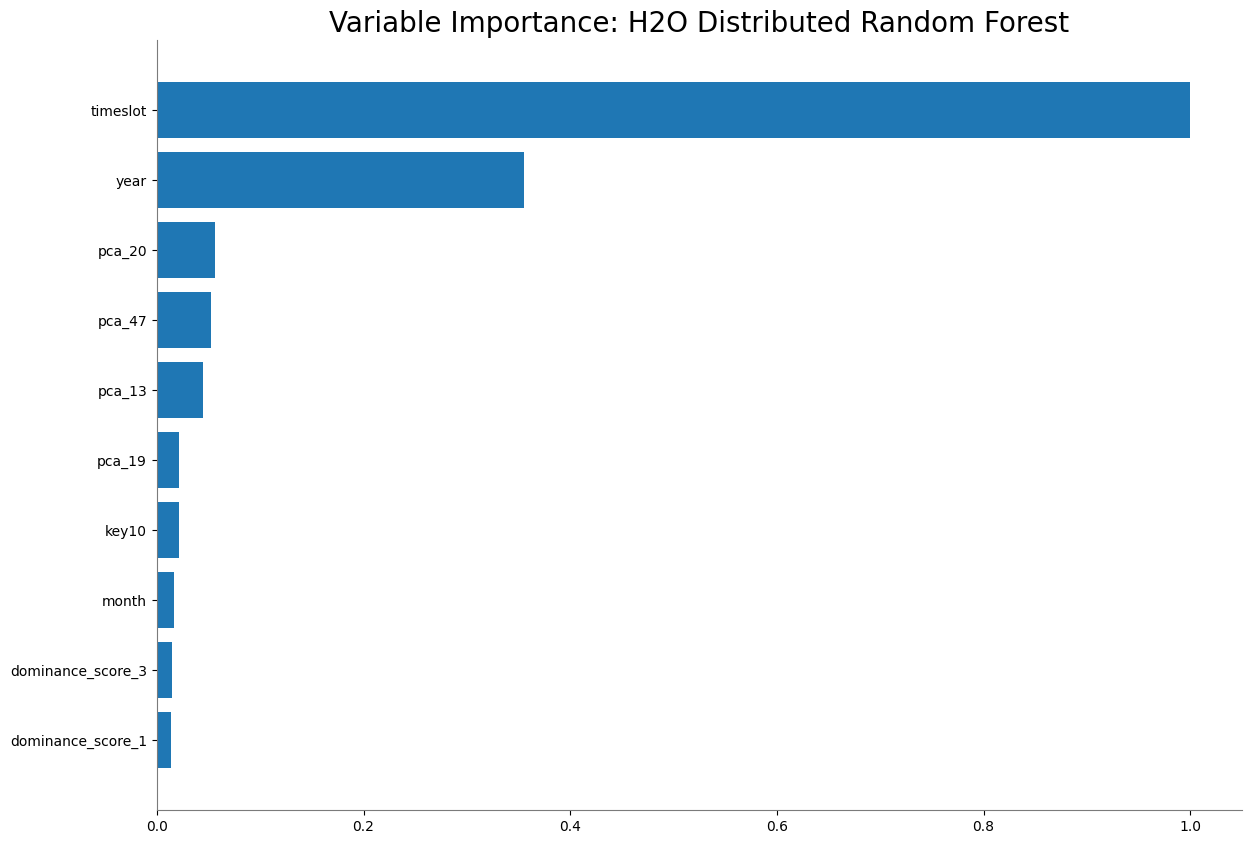

<Figure size 640x480 with 0 Axes>

In [241]:
# Get the model ID of the second model
model_id = leaderboard.as_data_frame().iloc[1, 0]
# Load the second model
model = h2o.get_model(model_id)

# Retrieve variable importance
importance = model.varimp(use_pandas=True)
print(importance)

# Plot variable importance
model.varimp_plot()


In [ ]:
importance.head(15)

In [273]:
# for tree based models

importance = best_model.varimp(use_pandas=True)
print(importance)

          variable  relative_importance  scaled_importance  percentage
0         timeslot          1186.360352           1.000000    0.548582
1             year           265.640686           0.223912    0.122834
2           pca_47            59.032845           0.049760    0.027297
3            key10            46.517189           0.039210    0.021510
4           pca_20            35.657837           0.030056    0.016488
..             ...                  ...                ...         ...
81          pca_26             0.691754           0.000583    0.000320
82  events_density             0.650636           0.000548    0.000301
83     numarticles             0.404028           0.000341    0.000187
84          pca_12             0.383239           0.000323    0.000177
85            key6             0.318695           0.000269    0.000147

[86 rows x 4 columns]


In [ ]:
# for GLM models (regressors type)

coefficients = best_model.coef()
print(coefficients)


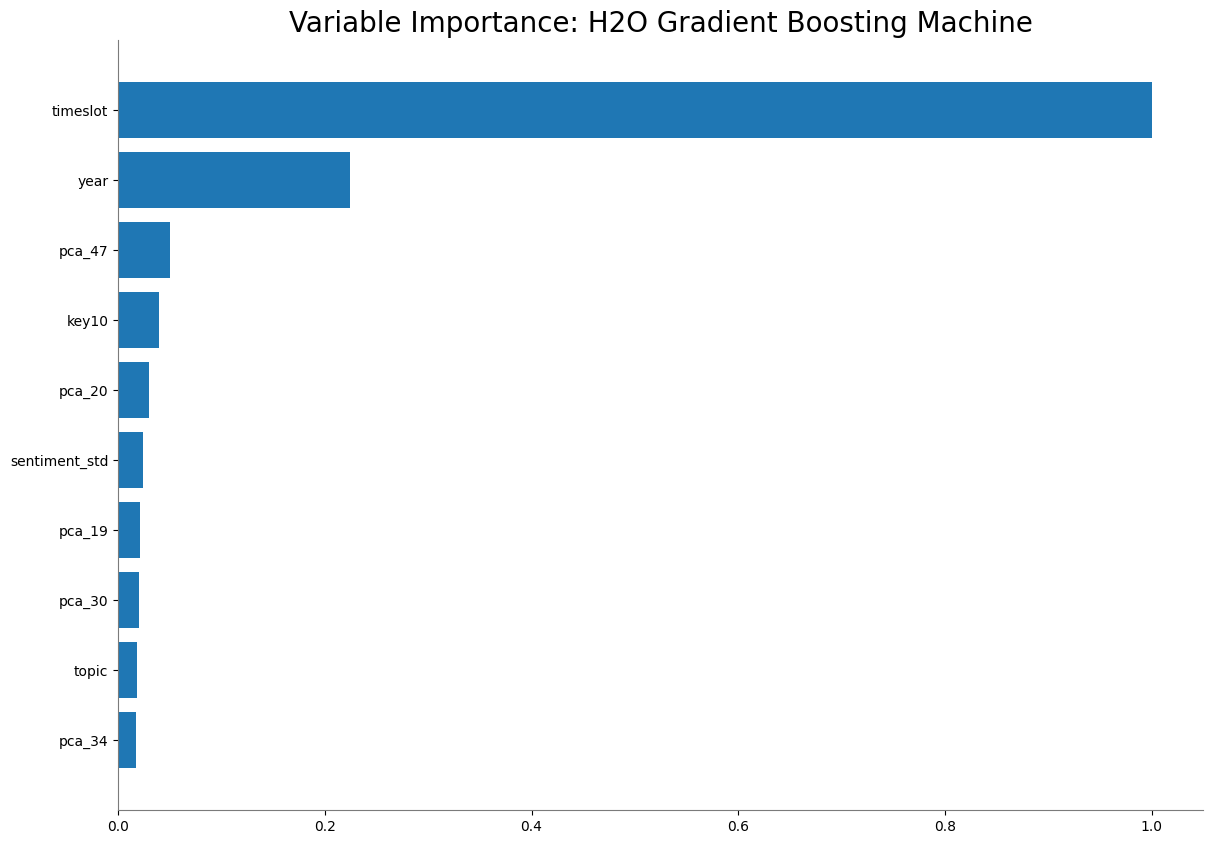

<Figure size 640x480 with 0 Axes>

In [275]:
best_model.varimp_plot()

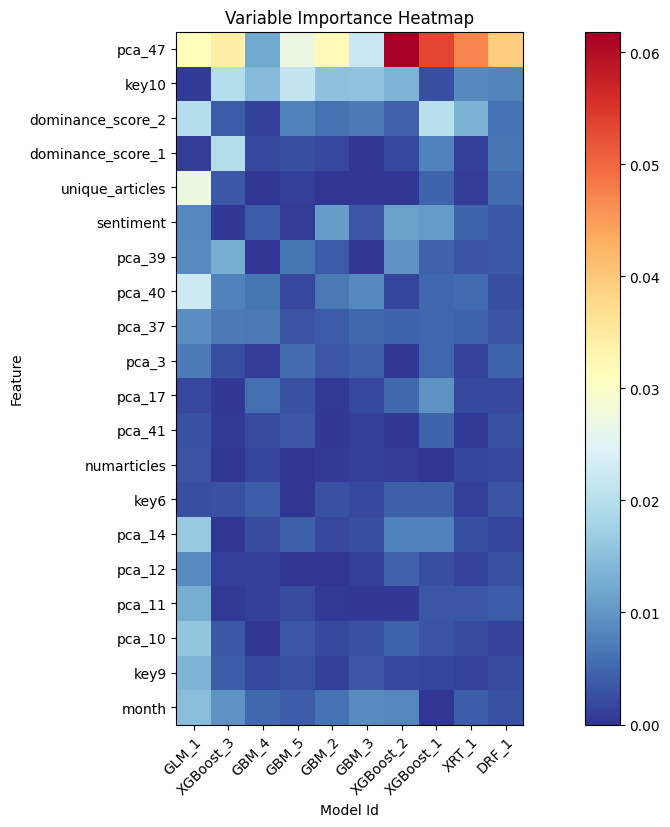

In [276]:
h2o.varimp_heatmap(aml.leaderboard)

In [ ]:
# The Stacked Ensemble's metalearner combines the base models' predictions. By examining its coefficients,
#you can understand the weight assigned to each base model, indirectly reflecting the importance of
#the features used by those models.
metalearner = h2o.get_model(aml.leader.metalearner()['name'])
print(metalearner.coef())


In [ ]:
# more nuanced look

shap_explain = best_model.predict_contributions(test_data)
print(shap_explain.head())


## **2. Testing with LLM feature - NOT DONE YET**

### Regression with GPR CEL Score

Regression with GPR CEL Score: 
Cross-Validated MSE: 0.29544315113215086
Cross-Validated RMSE: 0.5260051872721004
____________________________________________
Feature Importances:
                       Feature  Importance
16                   STARTDATE    0.342522
17                     ENDDATE    0.307852
25                        key5    0.051895
26                        key6    0.029506
0               goldsteinscale    0.027333
12                     topic_3    0.026641
28                        key8    0.021230
27                        key7    0.019687
9            dominance_score_1    0.015702
14                   sentiment    0.015468
11           dominance_score_2    0.014469
29                        key9    0.012858
3              unique_articles    0.012187
24                        key4    0.010498
18           gpt_probabilities    0.009103
8   cosine_similarity_negative    0.007901
22                        key2    0.007887
13           dominance_score_3    0.006989
6  

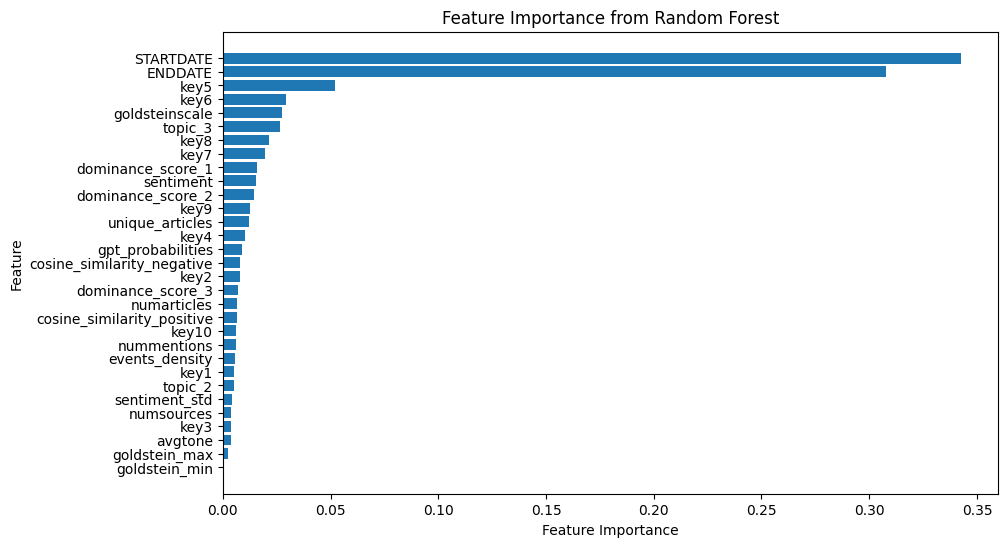

'\n######### RMSE analysis based on Y stats ########\n\n# RMSE analysis \n\nimport numpy as np\nimport pandas as pd\n\n# Example target variable statistics (replace with your actual target data)\ny = y\n\n# Given metrics\nrmse = rmse_scores.mean()  # Replace with your calculated RMSE\n\n# Compute target statistics\nmean = np.mean(y)\nstd_dev = np.std(y)\ntarget_range = np.max(y) - np.min(y)\nq1 = np.percentile(y, 25)  # 25th percentile\nq3 = np.percentile(y, 75)  # 75th percentile\niqr = q3 - q1\n\n# Comparisons\nrmse_std_ratio = rmse / std_dev\nrmse_range_ratio = rmse / target_range\nrmse_iqr_ratio = rmse / iqr\n\n# Print results and interpretations\nprint(f"RMSE: {rmse}")\nprint(f"Standard Deviation: {std_dev}")\nprint(f"RMSE / Standard Deviation: {rmse_std_ratio:.2f}")\nif rmse_std_ratio <= 1.0:\n    print("---Model performs reasonably well based on RMSE compared to the standard deviation.")\nelse:\n    print("---Model may need improvement based on RMSE compared to the standard devi

In [ ]:
# Regression WITH LLM feature

print("Regression with GPR CEL Score: ")

# Drop rows with missing target values
data = data.dropna(subset=['shifted_fatalities'])

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import numpy as np
import pandas as pd

# Prepare the data
X = data.drop(columns=['Unnamed: 0', 'timeslot', 'goldstein_min_max',
                       'avg_embeddings', 'topic', 'topic_1', 'strings',
                       'summaries', 'sum(ACLED_Fatalities)', 'importance',
                       'backlogged_importance', 'shifted_fatalities'])

y = np.log10(data['shifted_fatalities'])

# Standardize the numerical features
numerical_features = ['goldsteinscale', 'avgtone', 'events_density',
                      'unique_articles', 'nummentions', 'numsources',
                      'numarticles', 'cosine_similarity_positive',
                      'cosine_similarity_negative', 'dominance_score_1', 'dominance_score_2',
                      'dominance_score_3', 'sentiment', 'sentiment_std',
                      'goldstein_min', 'goldstein_max', 'gpt_probabilities']

scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Initialize the model
model = RandomForestRegressor(random_state=42, n_estimators=100)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

# Convert scores to positive MSE and calculate the mean RMSE
mse_scores = -cv_scores
rmse_scores = np.sqrt(mse_scores)
print(f"Cross-Validated MSE: {mse_scores.mean()}")
print(f"Cross-Validated RMSE: {rmse_scores.mean()}")
print("____________________________________________")

# Train the model on the entire dataset for feature importance analysis
model.fit(X, y)

# Extract feature importances
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display feature importance
print("Feature Importances:")
print(feature_importance_df)

# Optional: Plot the feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.show()




"""
######### RMSE analysis based on Y stats ########

# RMSE analysis

import numpy as np
import pandas as pd

# Example target variable statistics (replace with your actual target data)
y = y

# Given metrics
rmse = rmse_scores.mean()  # Replace with your calculated RMSE

# Compute target statistics
mean = np.mean(y)
std_dev = np.std(y)
target_range = np.max(y) - np.min(y)
q1 = np.percentile(y, 25)  # 25th percentile
q3 = np.percentile(y, 75)  # 75th percentile
iqr = q3 - q1

# Comparisons
rmse_std_ratio = rmse / std_dev
rmse_range_ratio = rmse / target_range
rmse_iqr_ratio = rmse / iqr

# Print results and interpretations
print(f"RMSE: {rmse}")
print(f"Standard Deviation: {std_dev}")
print(f"RMSE / Standard Deviation: {rmse_std_ratio:.2f}")
if rmse_std_ratio <= 1.0:
    print("---Model performs reasonably well based on RMSE compared to the standard deviation.")
else:
    print("---Model may need improvement based on RMSE compared to the standard deviation.")

print(f"Target Range: {target_range}")
print(f"RMSE / Target Range: {rmse_range_ratio:.2f}")
if rmse_range_ratio <= 0.2:
    print("---Model performs reasonably well based on RMSE compared to the target range.")
else:
    print("---Model may need improvement based on RMSE compared to the target range.")

print(f"IQR: {iqr}")
print(f"RMSE / IQR: {rmse_iqr_ratio:.2f}")
if rmse_iqr_ratio <= 0.5:
    print("---Model performs reasonably well based on RMSE compared to the interquartile range.")
else:
    print("---Model may need improvement based on RMSE compared to the interquartile range.")
"""

### Testing multiple regression models (with LLM feature)

In [ ]:
# testing multiple regression models (with LLM feature)

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, ElasticNet, Lasso, BayesianRidge, HuberRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

# Define all models to test
models = {
    "RandomForestRegressor": RandomForestRegressor(random_state=42, n_estimators=100),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=42),
    "Ridge": Ridge(alpha=8.0, random_state=42),
    "ElasticNet": ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42),
    "Lasso": Lasso(alpha=0.1, random_state=42),
    "BayesianRidge": BayesianRidge(),
    "HuberRegressor": HuberRegressor(epsilon=1.35),
    "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=5),
    "SVR": SVR(kernel='rbf', C=1.0, epsilon=0.1),
    "MLPRegressor": MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    "PolynomialRegression": make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
}

# Prepare the data
# Replace 'data' with your actual DataFrame
numerical_features = [
    'goldsteinscale', 'avgtone', 'events_density',
    'unique_articles', 'nummentions', 'numsources',
    'numarticles', 'cosine_similarity_positive',
    'cosine_similarity_negative', 'dominance_score_1', 'dominance_score_2',
    'dominance_score_3', 'sentiment', 'sentiment_std',
    'goldstein_min', 'goldstein_max', 'gpt_probabilities'
]

X = data.drop(columns=[
    'Unnamed: 0', 'timeslot', 'goldstein_min_max',
    'avg_embeddings', 'topic', 'topic_1', 'strings',
    'summaries', 'sum(ACLED_Fatalities)', 'importance', 'backlogged_importance',
    'shifted_fatalities'
])
y = np.log10(data['shifted_fatalities'])

# Standardize the numerical features
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Collect results
results = []

# Evaluate each model
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    mse_scores = -cv_scores
    rmse_scores = np.sqrt(mse_scores)
    results.append({
        "Model": model_name,
        "Mean MSE": mse_scores.mean(),
        "Mean RMSE": rmse_scores.mean()
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_

                        Model  Mean MSE  Mean RMSE
0       RandomForestRegressor  0.295443   0.526005
1   GradientBoostingRegressor  0.339572   0.563561
2                       Ridge  0.877279   0.904849
3                  ElasticNet  0.462535   0.664187
4                       Lasso  0.714658   0.827448
5               BayesianRidge  0.512464   0.687606
6              HuberRegressor  0.910305   0.918631
7         KNeighborsRegressor  0.455958   0.650116
8                         SVR  0.515525   0.686648
9                MLPRegressor  3.965787   1.950537
10       PolynomialRegression  0.707317   0.820608


### ⭐ AutoML adjusted for a small dataset (via hyperparams and CV)

In [ ]:
# AutoML but adjusted for a small dataset

# Install H2O
!pip install h2o

# Import H2O and other required libraries
import h2o
from h2o.automl import H2OAutoML
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Start the H2O cluster
h2o.init()

# Drop rows with missing target values
data = data.dropna(subset=['shifted_fatalities'])

# Prepare the data
X = data.drop(columns=['Unnamed: 0', 'timeslot', 'goldstein_min_max',
                       'avg_embeddings', 'topic', 'topic_1', 'strings',
                       'summaries', 'sum(ACLED_Fatalities)', 'importance',
                       'backlogged_importance', 'shifted_fatalities'])

y = np.log10(data['shifted_fatalities'])

# Standardize the numerical features
numerical_features = ['goldsteinscale', 'avgtone', 'events_density',
                      'unique_articles', 'nummentions', 'numsources',
                      'numarticles', 'cosine_similarity_positive',
                      'cosine_similarity_negative', 'dominance_score_1', 'dominance_score_2',
                      'dominance_score_3', 'sentiment', 'sentiment_std',
                      'goldstein_min', 'goldstein_max', 'gpt_probabilities']

scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Combine X and y into a single DataFrame for H2O
data_h2o = pd.concat([X, pd.Series(y, name='shifted_fatalities')], axis=1)

# Convert the DataFrame to an H2O Frame
data_h2o = h2o.H2OFrame(data_h2o)

# Specify predictors (features) and response (target)
predictors = X.columns.tolist()
response = 'shifted_fatalities'

# Run H2O AutoML with cross-validation
aml = H2OAutoML(max_models=10,          # Limit the number of models
                max_runtime_secs=300,   # Total runtime of 5 minutes
                nfolds=5,               # Use 5-fold cross-validation
                seed=42)                # Ensure reproducibility

aml.train(x=predictors, y=response, training_frame=data_h2o)

# Display the leaderboard
print("\nLeaderboard:")
print(aml.leaderboard)

# Get the best model
best_model = aml.leader

# Evaluate the best model using cross-validation metrics
print("\nModel Performance (Cross-Validation Metrics):")
print(best_model.cross_validation_metrics_summary())

# Shutdown H2O (optional)
h2o.shutdown(prompt=False)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.25" 2024-10-15; OpenJDK Runtime Environment (build 11.0.25+9-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.25+9-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpl10hby2s
  JVM stdout: /tmp/tmpl10hby2s/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpl10hby2s/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,1 month and 2 days
H2O_cluster_name:,H2O_from_python_unknownUser_ipvp7x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |██
18:11:27.334: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 23.0.

███
18:11:36.665: GBM_2_AutoML_1_20241204_181120 [GBM def_2] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_2_AutoML_1_20241204_181120.  Details: ERRR on field: _min_rows: The dataset size is too small to split for min_rows=10.0: must have at least 20.0 (weighted) rows, but have only 18.0.
ERRR on field: _min_rows: The dataset size is too small to split for min_rows=10.0: must have at least 20.0 (weighted) rows, but have only 18.0.
ERRR on field: _min_rows: The dataset size is too small to split for min_rows=10.0: must have at least 20.0 (weighted) rows, but have only 18.0.
ERRR on field: _min_rows: The dataset size is too small to split for min_rows=10.0: must hav

<ipython-input-16-094d8c9c631b>:68: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown(prompt=False)
